In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

# Feature Selection

First, we check feautures RFE ranking using Logistic regression and Catboost Classifier. The reasonable values are chosen for hyperparameters.

## RFE ranking

In [7]:
df = pd.read_parquet('data_5nullremoved/df_all_boolean12.parquet')

In [4]:
df_tmp = df.copy()
df_tmp = df_tmp.sample(frac=1).reset_index(drop=True)

In [6]:
X = df_tmp.drop('default', axis=1)
y = df_tmp.default
columns = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,stratify=y)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_mm = scaler.transform(X_train)
X_test_mm = scaler.transform(X_test)
X_mm = scaler.transform(X)

X_train = pd.DataFrame(X_train_mm, columns=columns)
X_test = pd.DataFrame(X_test_mm, columns=columns)
X = pd.DataFrame(X_mm, columns=columns)

In [8]:
logreg = LogisticRegression(penalty='l1',C=10.0,verbose=0,max_iter=100,
    class_weight=None, random_state=41, solver='liblinear')

rfe_logreg = RFE(logreg,n_features_to_select=10)

rfe_logreg = rfe_logreg.fit(X, y)

df_rfe_logreg = pd.DataFrame(columns=["feature","ranking"])
df_rfe_logreg['feature'] = columns
df_rfe_logreg['ranking'] = rfe_logreg.ranking_
df_rfe_logreg = df_rfe_logreg.sort_values(by="ranking")

In [10]:
catboost = CatBoostClassifier(border_count=70,
        class_weights={0.0: 1.0, 1.0: 1.0},
        depth=10, iterations=1000,    
        l2_leaf_reg = 10,
        learning_rate = 0.01,
        loss_function='Logloss',
        verbose=0)

rfe_cb = RFE(catboost,n_features_to_select=10)
rfe_cb = rfe_cb.fit(X, y)

In [11]:
df_rfe_cb = pd.DataFrame(columns=["feature","ranking"])
df_rfe_cb['feature'] = columns
df_rfe_cb['ranking'] = rfe_cb.ranking_
df_rfe_cb = df_rfe_cb.sort_values(by="ranking")

df_rfe_cb.columns = ['feature', 'cb']
df_rfe_logreg.columns = ['feature', 'log']

df_rfe=pd.merge(df_rfe_cb,df_rfe_logreg)

In [12]:
df_rfe

,feature,cb,log
0,age,1,5
1,max_paid_inv_0_24m,1,1
2,sum_capital_paid_account_0_12m,1,1
3,num_unpaid_bills,1,3
4,status_max_archived_0_24_months,1,10
5,sum_paid_inv_0_12m,1,7
6,num_arch_ok_0_12m,1,1
7,account_incoming_debt_vs_paid_0_24m,1,36
8,new_merchant_group,1,13
9,num_arch_ok_12_24m,1,1


# Iterative Feature Reduction

In this part, I reduced features one-by-one using feature importance, logistic regression weights and RFE ranking. We have to remember that the boolean variables added in the exploratory analysis part get the lowest feature importances. However, they can get large weights in Logistic regression model. The categorical parameters need to be dropped with corresponding boolean variables. In that way, Logistic regression and Catboost models give comparable results.     

In [8]:
df_tmp = df.drop([
        'boolean_status_max_archived_0_24_months',
        'account_incoming_debt_vs_paid_0_24m',
        'has_paid',
        'boolean_account_status',
        'account_status',
        'account_amount_added_12_24m',
         'boolean_status_max_archived_0_6_months',
         'status_max_archived_0_6_months',
         'boolean_worst_status_active_inv',
        'account_worst_status_12_24m',
        'boolean_account_worst_status_12_24m',
        'account_days_in_dc_12_24m',
        'num_arch_ok_12_24m',
        'status_max_archived_0_24_months',
        'status_max_archived_0_12_months',
        'boolean_status_max_archived_0_12_months',
        'status_3rd_last_archived_0_24m',
        'boolean_status_3rd_last_archived_0_24m',
        'worst_status_active_inv',
        'boolean_worst_status_active_inv',
        'recovery_debt',
        'status_2nd_last_archived_0_24m',
        'boolean_status_2nd_last_archived_0_24m',
        'sum_capital_paid_account_12_24m',
        'account_days_in_term_12_24m',
        'num_arch_dc_12_24m',
        'account_days_in_rem_12_24m',
        'account_worst_status_3_6m',
        'boolean_account_worst_status_3_6m',
        'num_arch_ok_0_12m',
        'num_active_inv',
        'boolean_account_worst_status_6_12m',
        'account_worst_status_6_12m'
        ],1)

In [9]:
X = df_tmp.drop('default', axis=1)
y = df_tmp.default
columns = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,stratify=y)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_mm = scaler.transform(X_train)
X_test_mm = scaler.transform(X_test)
X_mm = scaler.transform(X)

X_train = pd.DataFrame(X_train_mm, columns=columns)
X_test = pd.DataFrame(X_test_mm, columns=columns)
X = pd.DataFrame(X_mm, columns=columns)

In [10]:
cgb = CatBoostClassifier(border_count=70,
        class_weights={0.0: 1.0, 1.0: 1.0},
        depth=10, iterations=1000,    
        l2_leaf_reg = 30,
        learning_rate = 0.01,
        loss_function='Logloss',
        verbose=0)

cgb.fit(X_train, y_train)

In [11]:
logreg = LogisticRegression(penalty='l1',C=10.0,verbose=0,max_iter=100,
    class_weight=None, random_state=41, solver='liblinear')

logreg.fit(X_train,y_train)

LogisticRegression(C=10.0, penalty='l1', random_state=41, solver='liblinear')

Roc curves for test and training datasets are shown below. The results look reasonable. CatBoost Model slightly overfit. Due to statistical uncertainty, the logistic regression got higher value for testing dataset. 

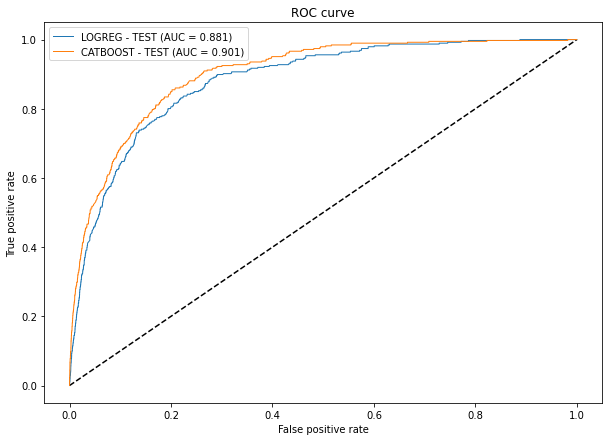

In [22]:
import utils
roc_test=utils.plot_RocCurve_models(X_test, y_test, [logreg,cgb],\
                ["LOGREG - TEST","CATBOOST - TEST"] )

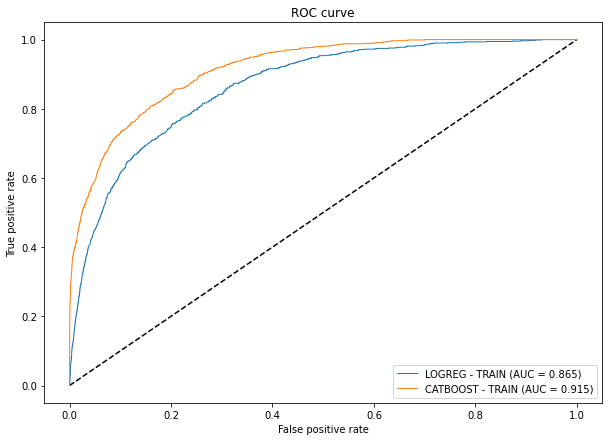

In [23]:
roc_train=utils.plot_RocCurve_models(X_train, y_train, [logreg,cgb],\
                ["LOGREG - TRAIN","CATBOOST - TRAIN"]) 

Feature ranking:
1. feature sum_paid_inv_0_12m (14.985447)
2. feature age (12.133187)
3. feature new_merchant_group (11.363389)
4. feature status_last_archived_0_24m (9.602837)
5. feature num_unpaid_bills (8.634415)
6. feature account_worst_status_0_3m (8.177345)
7. feature max_paid_inv_0_24m (7.683158)
8. feature sum_capital_paid_account_0_12m (7.162321)
9. feature max_paid_inv_0_12m (6.036980)
10. feature boolean_account_worst_status_0_3m (4.895443)
11. feature num_arch_rem_0_12m (4.028433)
12. feature num_arch_dc_0_12m (2.955166)
13. feature boolean_status_last_archived_0_24m (2.341879)


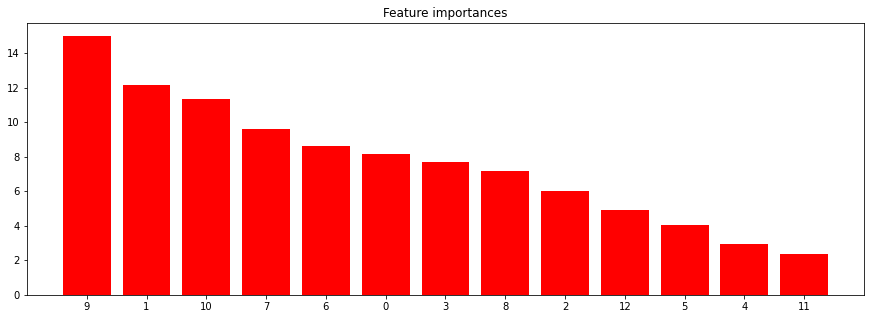

In [14]:
df_features_cb = utils.plot_feature_importance(cgb,X)

# Gridsearch Hyper-Parameters

In this section, we are showing hyperparameter tuning. I did hyperparameter tuning with both roc_auc_score and brier loss score since our final goal is to predict probability. Usually, I do RandomizedSearchCV first and then, do GridSearch when I am working on big datasets. In this case, i mostly did GridSearch. 

## Logistic Regression

### Logistic Regression with RocAUC

In [16]:
kf = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

In [18]:
logit = LogisticRegression(penalty='l2', C=1, solver='liblinear', class_weight='balanced', max_iter=3000, 
                           random_state=8)

logit_gs_params = {'penalty':['l1', 'l2'],
                   'solver': ['liblinear'],
                   'C': [0.001, 0.01, 0.1, 1, 10],
                   'class_weight':[{0.0: 0.5072586328400281, 1.0: 34.94174757281554},
                    {0.0: 1.0, 1.0: 20.0},{0.0: 1.0, 1.0: 10.0},{0.0: 1.0, 1.0: 1.0}],
                  }

In [19]:
gs_logit = GridSearchCV(logit, logit_gs_params, scoring='roc_auc',refit=True, cv=kf, verbose=2, n_jobs=-1)
gs_logit = gs_logit.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [20]:
gs_logit.best_params_

{'C': 10,
 'class_weight': {0.0: 0.5072586328400281, 1.0: 34.94174757281554},
 'penalty': 'l1',
 'solver': 'liblinear'}

In [21]:
gs_logit.best_score_

0.8689559161066897

In [53]:
logit = LogisticRegression(penalty='l2', C=1, solver='liblinear', class_weight='balanced', max_iter=3000, 
                           random_state=8)

gs_logit = GridSearchCV(logit, logit_gs_params, scoring='neg_brier_score',refit=True, cv=kf, verbose=2, n_jobs=-1)
gs_logit = gs_logit.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [54]:
gs_logit.best_params_

{'C': 1,
 'class_weight': {0.0: 1.0, 1.0: 1.0},
 'penalty': 'l2',
 'solver': 'liblinear'}

In [56]:
print(gs_logit.best_score_)

-0.01345965922223246


## CatBoost

### Grid Search With RocAUC

In [33]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200]
         }

In [36]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0.0: 0.5072647025660025, 1.0: 34.9129711751663}

In [41]:
%%time

gbm = CatBoostClassifier(
    class_weights=class_weights,verbose=False)

random_search = RandomizedSearchCV(gbm, param_distributions=params, n_iter=20, \
    scoring="roc_auc",n_jobs=-1,cv=3, random_state=1001 )

random_search.fit(X_train, y_train)

CPU times: user 35 s, sys: 8.29 s, total: 43.3 s
Wall time: 1min 22s


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f9fc63f9150>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'border_count': [32, 5, 10, 20, 50, 100,
                                                         200],
                                        'depth': [3, 1, 2, 6, 4, 5, 7, 8, 9,
                                                  10],
                                        'iterations': [250, 100, 500, 1000],
                                        'l2_leaf_reg': [3, 1, 5, 10, 100],
                                        'learning_rate': [0.03, 0.001, 0.01,
                                                          0.1, 0.2, 0.3]},
                   random_state=1001, scoring='roc_auc')

In [42]:
print('\n Best scoring:')
print(random_search.best_score_ )
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best scoring:
0.8978886198146

 Best hyperparameters:
{'learning_rate': 0.03, 'l2_leaf_reg': 100, 'iterations': 250, 'depth': 8, 'border_count': 10}


In [58]:
params_grid = {'depth':[7],
          'iterations':[1000],
          'learning_rate':[0.01], 
          'class_weights':[{0.0: 0.5072586328400281, 1.0: 34.94174757281554},{0.0: 1.0, 1.0: 10.0},{0.0: 1.0, 1.0: 1.0}],
          'l2_leaf_reg':[100,200,300],
          'border_count':[30,50,100],
            'loss_function': ['Logloss','CrossEntropy'],
         }

In [59]:
%%time

gbm = CatBoostClassifier(class_weights=class_weights,verbose=False)

grid_clf = GridSearchCV(gbm, param_grid=params_grid,\
    scoring="roc_auc",n_jobs=-1,cv=3, verbose=False)

grid_clf.fit(X_train, y_train)

CPU times: user 1min 50s, sys: 21.7 s, total: 2min 12s
Wall time: 4min 47s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f9fc6c8f610>,
             n_jobs=-1,
             param_grid={'border_count': [30, 50, 100],
                         'class_weights': [{0.0: 0.5072586328400281,
                                            1.0: 34.94174757281554},
                                           {0.0: 1.0, 1.0: 10.0},
                                           {0.0: 1.0, 1.0: 1.0}],
                         'depth': [7], 'iterations': [1000],
                         'l2_leaf_reg': [100, 200, 300],
                         'learning_rate': [0.01],
                         'loss_function': ['Logloss']},
             scoring='roc_auc', verbose=False)

In [60]:
grid_clf.best_params_

{'border_count': 50,
 'class_weights': {0.0: 1.0, 1.0: 10.0},
 'depth': 7,
 'iterations': 1000,
 'l2_leaf_reg': 100,
 'learning_rate': 0.01,
 'loss_function': 'Logloss'}

### GridSearch with Brier Loss score

In [68]:
params_grid = {'depth':[7],
          'iterations':[1000],
          'learning_rate':[0.01], 
          'class_weights':[{0.0: 1.0, 1.0: 10.0},{0.0: 1.0, 1.0: 5.0},{0.0: 1.0, 1.0: 3.0},{0.0: 1.0, 1.0: 2.0}],
          'l2_leaf_reg':[30,50,100],
          'border_count':[30,50,70],
            'loss_function': ['Logloss'],
         }

In [69]:
%%time

gbm = CatBoostClassifier(class_weights=class_weights,verbose=False)

grid_clf = GridSearchCV(gbm, param_grid=params_grid,\
    scoring="neg_brier_score",n_jobs=-1,cv=3, verbose=False)

grid_clf.fit(X_train, y_train)

CPU times: user 1min 46s, sys: 22.1 s, total: 2min 8s
Wall time: 6min 14s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f9fd5bdbcd0>,
             n_jobs=-1,
             param_grid={'border_count': [30, 50, 70],
                         'class_weights': [{0.0: 1.0, 1.0: 10.0},
                                           {0.0: 1.0, 1.0: 5.0},
                                           {0.0: 1.0, 1.0: 3.0},
                                           {0.0: 1.0, 1.0: 2.0}],
                         'depth': [7], 'iterations': [1000],
                         'l2_leaf_reg': [30, 50, 100], 'learning_rate': [0.01],
                         'loss_function': ['Logloss']},
             scoring='neg_brier_score', verbose=False)

In [70]:
grid_clf.best_params_

{'border_count': 70,
 'class_weights': {0.0: 1.0, 1.0: 2.0},
 'depth': 7,
 'iterations': 1000,
 'l2_leaf_reg': 30,
 'learning_rate': 0.01,
 'loss_function': 'Logloss'}

In [75]:
params_grid = {'depth':[7],
          'iterations':[1000],
          'learning_rate':[0.01], 
          'class_weights':[{0.0: 0.5072586328400281, 1.0: 34.94174757281554},{0.0: 1.0, 1.0: 10.0}],
          'l2_leaf_reg':[30,50,100],
          'border_count':[30,50,70],
            'loss_function': ['Logloss'],
         }

In [76]:
%%time

gbm = CatBoostClassifier(class_weights=class_weights,verbose=False)

grid_clf = GridSearchCV(gbm, param_grid=params_grid,\
    scoring="roc_auc",n_jobs=-1,cv=3, verbose=False)

grid_clf.fit(X_train, y_train)

CPU times: user 1min 44s, sys: 22.2 s, total: 2min 7s
Wall time: 3min 16s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f9fd5ca2210>,
             n_jobs=-1,
             param_grid={'border_count': [30, 50, 70],
                         'class_weights': [{0.0: 0.5072586328400281,
                                            1.0: 34.94174757281554},
                                           {0.0: 1.0, 1.0: 10.0}],
                         'depth': [7], 'iterations': [1000],
                         'l2_leaf_reg': [30, 50, 100], 'learning_rate': [0.01],
                         'loss_function': ['Logloss']},
             scoring='roc_auc', verbose=False)

In [77]:
grid_clf.best_params_

{'border_count': 50,
 'class_weights': {0.0: 1.0, 1.0: 10.0},
 'depth': 7,
 'iterations': 1000,
 'l2_leaf_reg': 50,
 'learning_rate': 0.01,
 'loss_function': 'Logloss'}